## Importing basic libraries

In [32]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## Importing Data

In [2]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews',split=['train','test[:50%]','test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR73EMH/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR73EMH/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR73EMH/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
for review,label in train_ds.shuffle(buffer_size=15).take(5):
  print(review.numpy())
  print(label.numpy())

b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'
1
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug i

## Text Standardization

In [4]:
def standardization(inp_text):
  no_html=tf.strings.regex_replace(inp_text,"<[^>]+>","") # removing html tags
  no_spl_char=tf.strings.regex_replace(no_html,"[^a-zA-Z0-9\s]","") # removing special chars,punctuations
  no_upper=tf.strings.lower(no_spl_char) # lower case
  return no_upper



In [5]:
# getting vocabularies
vectors=tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=200
)

In [6]:
training_data=train_ds.map(lambda x,y:x)

In [7]:
vectors.adapt(training_data)

In [8]:
len(vectors.get_vocabulary())

10000

In [9]:
# getting the review and label---> converting it into respective vector---> returning it along with label
def vectorization(review,label):
  return vectors(review),label

In [10]:
training_reviews=train_ds.map(vectorization)
validation_reviews=val_ds.map(vectorization)

In [11]:
for review,label in training_reviews.take(1):
  print(review)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3522   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  483   54   64   84  111   95   21 5502   10   91  636  736   10
   17    7   33  393 9553  169 2442  406    2   87 1204  135   65  142
   52    2    1 7407   65  245   64 2832   16    1 2850    1    1 1415
 4971    3   39    1 1561   15 3522   13  156   18    4 1204  880 7872
    8    4   17   12   13 4036    5   98  145 1232   11  236  695   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1147  840  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [29]:
train_dataset=training_reviews.batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=validation_reviews.batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Building

### SimpleRNN

In [16]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Input(250,),
    tf.keras.layers.Embedding(100,50),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 50)           5000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                1420      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 6,441
Trainable params: 6,441
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics="accuracy")

In [30]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
391/391 [==============================] - 141s 359ms/step - loss: 0.6915 - accuracy: 0.5173 - val_loss: 0.6936 - val_accuracy: 0.5037
Epoch 2/10
391/391 [==============================] - 102s 260ms/step - loss: 0.6886 - accuracy: 0.5332 - val_loss: 0.6933 - val_accuracy: 0.5142
Epoch 3/10
391/391 [==============================] - 97s 248ms/step - loss: 0.6859 - accuracy: 0.5419 - val_loss: 0.6962 - val_accuracy: 0.5054
Epoch 4/10
391/391 [==============================] - 96s 247ms/step - loss: 0.6834 - accuracy: 0.5456 - val_loss: 0.6973 - val_accuracy: 0.5094
Epoch 5/10
391/391 [==============================] - 101s 258ms/step - loss: 0.6800 - accuracy: 0.5516 - val_loss: 0.6986 - val_accuracy: 0.5101
Epoch 6/10
391/391 [==============================] - 98s 249ms/step - loss: 0.6772 - accuracy: 0.5548 - val_loss: 0.7007 - val_accuracy: 0.5127
Epoch 7/10
391/391 [==============================] - 104s 266ms/step - loss: 0.6743 - accuracy: 0.5632 - val_loss: 0.7017 - va

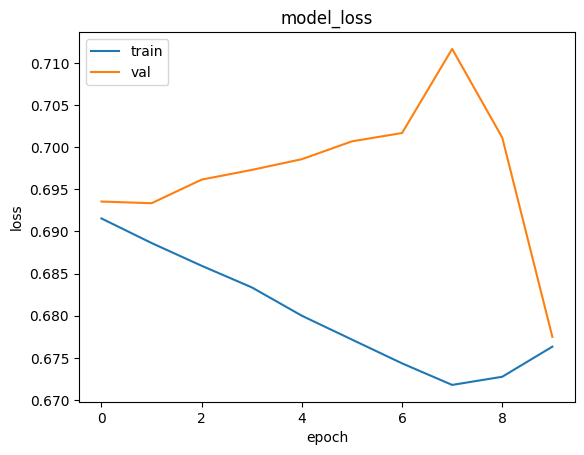

In [33]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

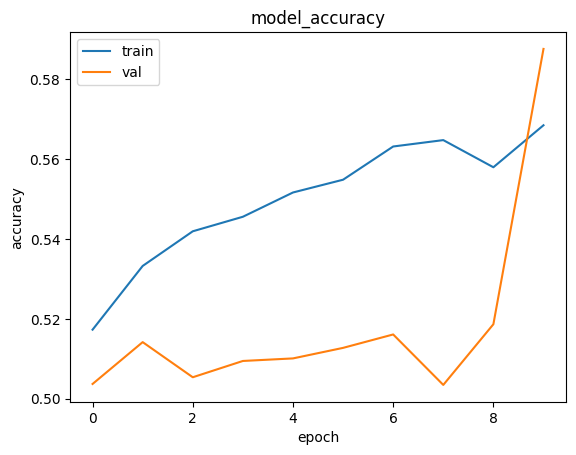

In [34]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
# Evaluation

test_dataset=test_ds.map(vectorization)
test_dataset=test_dataset.batch(64)
model.evaluate(test_dataset)

196/196 [==============================] - 7s 36ms/step - loss: 0.6779 - accuracy: 0.5858


[0.6778687238693237, 0.5858399868011475]

### LSTM

In [38]:
train_dataset=training_reviews.batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=validation_reviews.batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
model_lstm=tf.keras.models.Sequential([
    tf.keras.layers.Input(250,),
    tf.keras.layers.Embedding(100,50),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [40]:
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics="accuracy")

In [41]:
history_lstm=model_lstm.fit(train_dataset,validation_data=val_dataset,epochs=5)

Epoch 1/5
196/196 [==============================] - 49s 231ms/step - loss: 0.6907 - accuracy: 0.5211 - val_loss: 0.6923 - val_accuracy: 0.5163
Epoch 2/5
196/196 [==============================] - 12s 59ms/step - loss: 0.6902 - accuracy: 0.5417 - val_loss: 0.6979 - val_accuracy: 0.5078
Epoch 3/5
196/196 [==============================] - 11s 58ms/step - loss: 0.6894 - accuracy: 0.5294 - val_loss: 0.6853 - val_accuracy: 0.5557
Epoch 4/5
196/196 [==============================] - 13s 67ms/step - loss: 0.6780 - accuracy: 0.5756 - val_loss: 0.6701 - val_accuracy: 0.5922
Epoch 5/5
196/196 [==============================] - 19s 97ms/step - loss: 0.6879 - accuracy: 0.5245 - val_loss: 0.6911 - val_accuracy: 0.5145


In [42]:
model_lstm=tf.keras.models.Sequential([
    tf.keras.layers.Input(250,),
    tf.keras.layers.Embedding(100,50),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [45]:
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics="accuracy")

In [46]:
history_lstm=model_lstm.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
196/196 [==============================] - 34s 162ms/step - loss: 0.6022 - accuracy: 0.6910 - val_loss: 0.5905 - val_accuracy: 0.7038
Epoch 2/10
196/196 [==============================] - 11s 57ms/step - loss: 0.5794 - accuracy: 0.7005 - val_loss: 0.5704 - val_accuracy: 0.6951
Epoch 3/10
196/196 [==============================] - 13s 67ms/step - loss: 0.5754 - accuracy: 0.6971 - val_loss: 0.5669 - val_accuracy: 0.7029
Epoch 4/10
196/196 [==============================] - 11s 57ms/step - loss: 0.5697 - accuracy: 0.7038 - val_loss: 0.5636 - val_accuracy: 0.7081
Epoch 5/10
196/196 [==============================] - 13s 67ms/step - loss: 0.5624 - accuracy: 0.7106 - val_loss: 0.5595 - val_accuracy: 0.7112
Epoch 6/10
196/196 [==============================] - 11s 58ms/step - loss: 0.5600 - accuracy: 0.7100 - val_loss: 0.5549 - val_accuracy: 0.7099
Epoch 7/10
196/196 [==============================] - 12s 63ms/step - loss: 0.5576 - accuracy: 0.7113 - val_loss: 0.5537 - val_accuracy

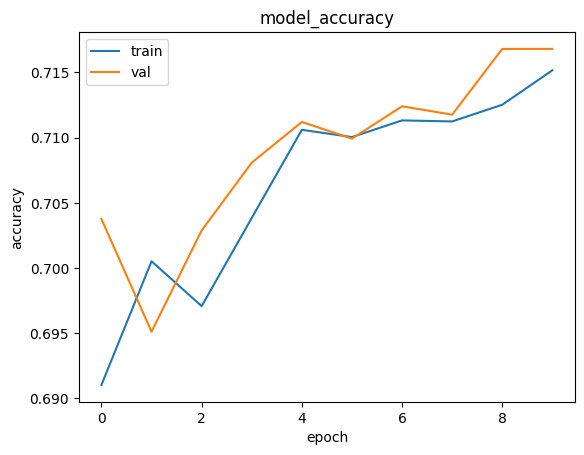

In [47]:
# accuracy
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
# Evaluation

test_dataset=test_ds.map(vectorization)
test_dataset=test_dataset.batch(64)
model_lstm.evaluate(test_dataset)

196/196 [==============================] - 4s 20ms/step - loss: 0.5447 - accuracy: 0.7154


[0.5447118282318115, 0.7154399752616882]